0.054309


<Axes: ylabel='Frequency'>

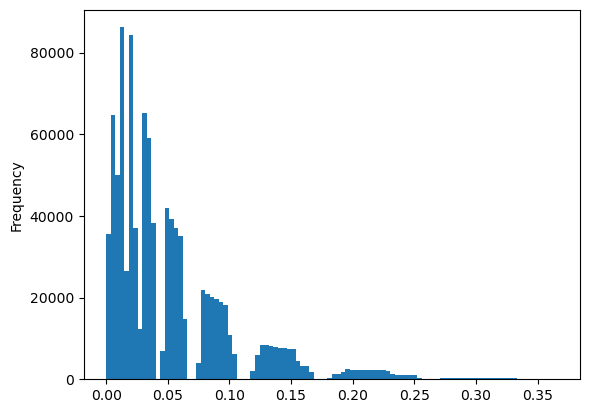

In [1]:
#############################################
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Creating simulated data

np.random.seed(10)
total_cases = 1000000
x1 = np.random.uniform(size=total_cases)
x2 = np.random.binomial(1, 0.5, size=total_cases)
x3 = np.random.poisson(5, size=total_cases)
y_logit = -1 + 0.3 * x1 + 0.1 * x2 + -0.5 * x3 + 0.05 * x1 * x2 + -0.03 * x2 * x3
y_probability = 1 / (1 + np.exp(-y_logit))
y_binary = np.random.binomial(1, y_probability)
columns = ['x1', 'x2', 'x3', 'y_probability', 'y_binary']
data = pd.DataFrame(zip(x1, x2, x3, y_probability, y_binary),
                    columns=columns)
x_vars = columns[:3]
y_var = columns[-1]

# Checking the distribution, make intercept larger if
# Not enough 0's to your liking
print(data[y_var].mean())
data['y_probability'].plot(kind='hist', bins=100)
#############################################

In [3]:
# Creating test/train samples
train = data[data.index <= 700000 * 0.8].copy()
test = data[data.index > 700000 * 0.8].copy()

In [4]:
# Downsampling the training dataset so classes are equal
n_of_positives = train['y_binary'].sum()  # Number of positives
pct_of_positives = train['y_binary'].mean()  # Percentage of positives

downsampled_negatives = train[train['y_binary'] == 0].sample(n=n_of_positives)
downsampled_positives = train[train['y_binary'] == 1]
downsampled_train = pd.concat(
    [downsampled_negatives, downsampled_positives], axis=0)

downsampled_pct_of_positives = downsampled_train[y_var].mean()  # % of positives
print(downsampled_pct_of_positives)
#############################################

0.5


In [5]:
#############################################
# Upping the number of trees for a higher resolution of
# predicted probabilities
model = XGBClassifier(n_estimators=1000)
model.fit(downsampled_train[x_vars], downsampled_train[y_var])

# making predictions probability for the test set
y_pred = model.predict_proba(test[x_vars])
test['downsampled_pred_prob'] = y_pred[:, 1]

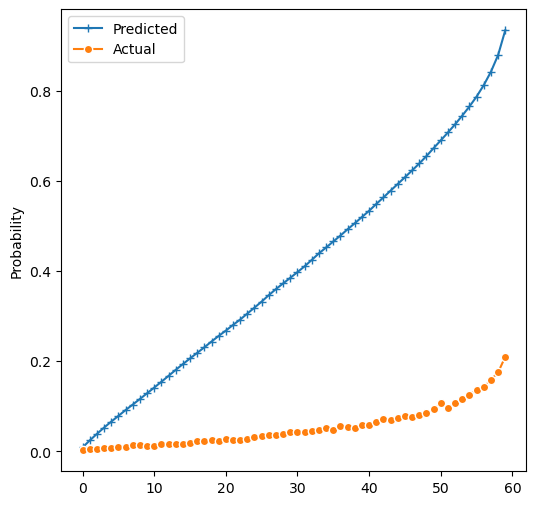

In [6]:
# Now looking at the calibration
def cal_data(prob, true, data, bins, plot=False, figsize=(6, 4), save_plot=False):
  calibration_data = data[[prob, true]].copy()
  calibration_data['Count'] = 1
  calibration_data['Bins'] = pd.qcut(calibration_data[prob], bins)

  agg_bins = calibration_data.groupby('Bins', as_index=False)[
      ['Count', prob, true]].sum()
  agg_bins['Predicted'] = agg_bins[prob] / agg_bins['Count']
  agg_bins['Actual'] = agg_bins[true] / agg_bins['Count']

  if plot:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(agg_bins.index, agg_bins['Predicted'],
            marker='+', label='Predicted')
    ax.plot(agg_bins.index, agg_bins['Actual'],
            marker='o', markeredgecolor='w', label='Actual')
    ax.set_ylabel('Probability')
    ax.legend(loc='upper left')
    plt.show()

    if save_plot:
      plt.savefig(save_plot, dpi=500, bbox_inches='tight')
    plt.show()

  return agg_bins


cal_down = cal_data(prob='downsampled_pred_prob', true=y_var,
                    data=test, bins=60,
                    plot=True, figsize=(6, 6))
#############################################

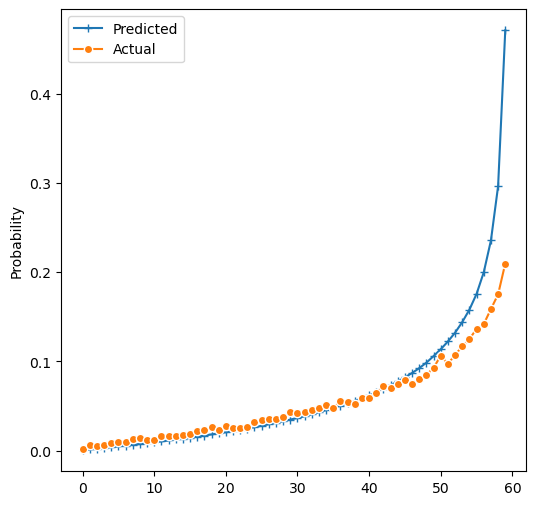

In [7]:
#############################################
# Rebalancing function

# rewrite from
# https://github.com/matloff/regtools/blob/master/inst/UnbalancedClasses.md
# and https://www.listendata.com/2015/04/oversampling-for-rare-event.htm
def adjust_class(conditional_probability, wrongprob, trueprob):
  a = conditional_probability / (wrongprob / trueprob)
  comp_cond = 1 - conditional_probability
  comp_wrong = 1 - wrongprob
  comp_true = 1 - trueprob
  b = comp_cond / (comp_wrong / comp_true)
  return a / (a + b)


test['adj_downsampled_pred_prob'] = adjust_class(test['downsampled_pred_prob'],
                                                 downsampled_pct_of_positives,
                                                 pct_of_positives)

cal_adj = cal_data(prob='adj_downsampled_pred_prob', true=y_var, data=test, bins=60,
                   plot=True, figsize=(6, 6))
#############################################

In [9]:
# Show classification report based on y_binary and downsampled_pred_prob
from sklearn.metrics import classification_report
print("Unadjusted")
print(classification_report(test[y_var], test['downsampled_pred_prob'] >= 0.5))

print("Adjusted")
print(classification_report(test[y_var],
      test['adj_downsampled_pred_prob'] >= 0.5))

Unadjusted
              precision    recall  f1-score   support

           0       0.97      0.65      0.78    416282
           1       0.10      0.69      0.18     23717

    accuracy                           0.66    439999
   macro avg       0.54      0.67      0.48    439999
weighted avg       0.93      0.66      0.75    439999

Adjusted
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    416282
           1       0.22      0.02      0.04     23717

    accuracy                           0.94    439999
   macro avg       0.59      0.51      0.50    439999
weighted avg       0.91      0.94      0.92    439999



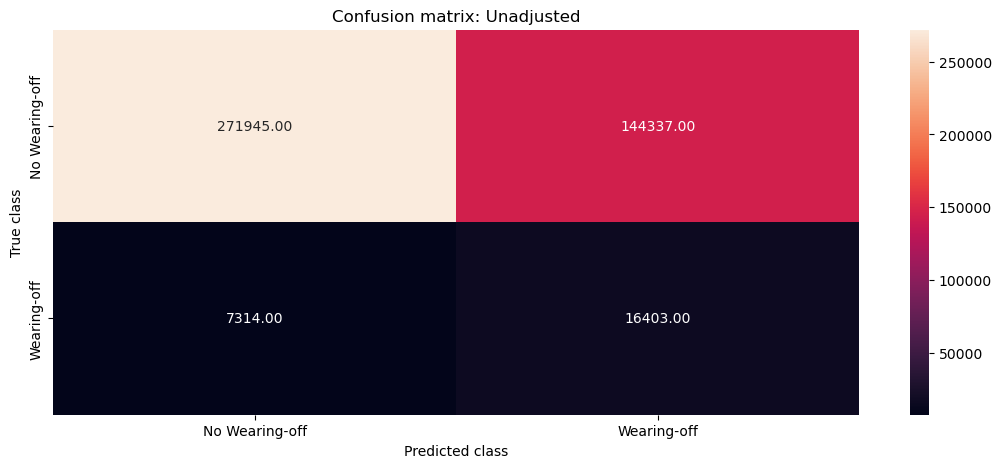

In [12]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
LABELS = ['No Wearing-off', 'Wearing-off']

conf_matrix = confusion_matrix(test[y_var],
                               test['downsampled_pred_prob'] >= 0.5,
                               normalize=None)
plt.figure(figsize=(13, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt=".2f")
plt.title(f"Confusion matrix: Unadjusted")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

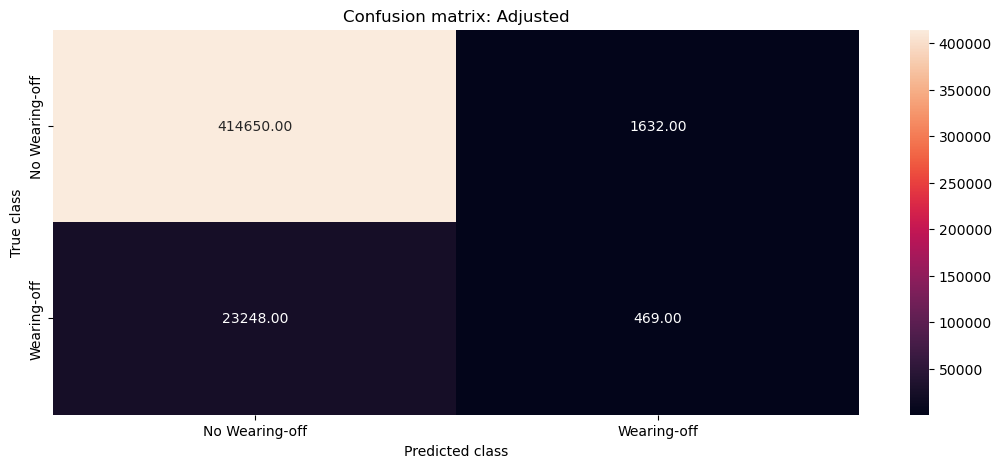

In [13]:
conf_matrix = confusion_matrix(test[y_var],
                               test['adj_downsampled_pred_prob'] >= 0.5,
                               normalize=None)
plt.figure(figsize=(13, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt=".2f")
plt.title(f"Confusion matrix: Adjusted")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

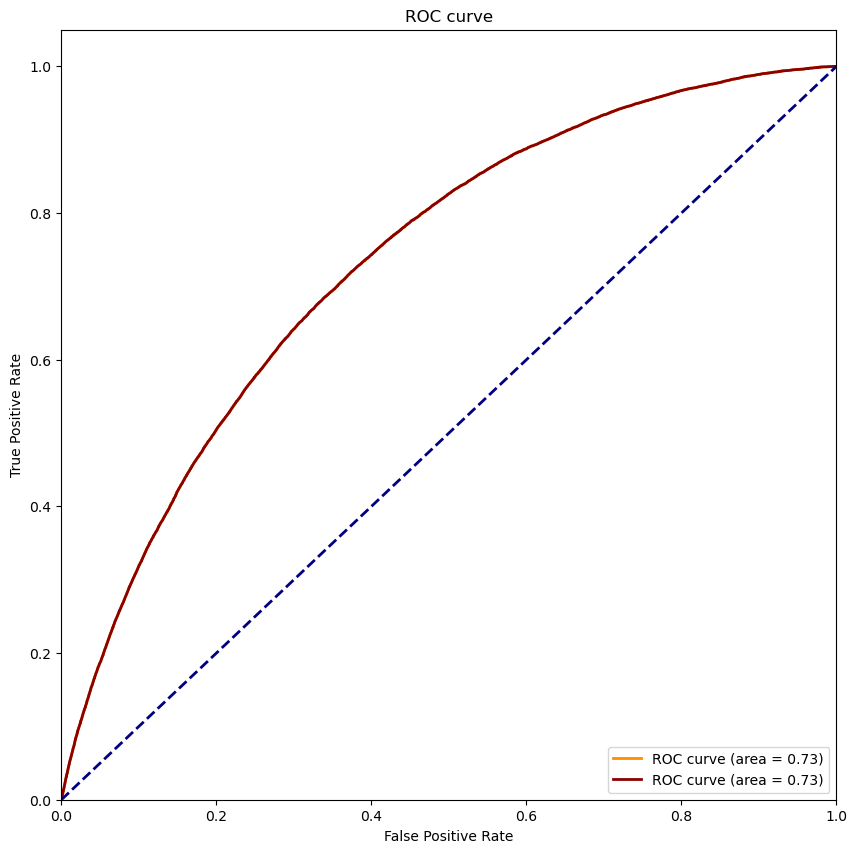

In [14]:
# Compute and graph ROC curve and AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test[y_var], test['downsampled_pred_prob'])
roc_auc = auc(fpr, tpr)


adj_fpr, adj_tpr, adj_thresholds = roc_curve(
    test[y_var], test['adj_downsampled_pred_prob'])
adj_roc_auc = auc(adj_fpr, adj_tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(adj_fpr, adj_tpr, color='darkred',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',
         lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()